In [1]:
from carlo_utils import get_data
import pandas as pd
import numpy as np
from src.models.decisiontrees.lightgbm import LGBM1
from tqdm import tqdm
import warnings
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv('data/datasets2025/historical_metering_data_IT.csv')
all_cols = dataframe.columns
all_cols = all_cols.drop('DATETIME')
all_indexes = all_cols.str.split('IT_', expand=False)
all_indexes = [int(index) for name,index in all_indexes]


In [3]:
preds_august = []
preds_july = []
true_july = []

cutoff = pd.to_datetime('2024-06-01')
cutoff2 = pd.to_datetime('2024-07-01')


In [ ]:
for index in tqdm(all_indexes):
    
    all_data = get_data(
        country='IT',
        customer_index = [index],
        demand=[0]+[i for i in range(8730,8760)]+[i for i in range(0,800,4)],
        temp=[0, 1,2,3,4,5,6, 24, 24*7, 24*365],
        spv=[0,2,3,4,5,6, 1, 24, 24*7, 24*365],
        forecast_shifts=[31],
        rollout_values=[i for i in range(0,24*31,4)],
        moving_average=[24, 24*7, 24*30,24*90,24*365],)
    
    

    train_data = all_data[all_data.index < cutoff]
    test_data = all_data[all_data.index >= cutoff]
    forecast_data = test_data[test_data.index < cutoff2]

    


    forecast_columns = train_data.columns[train_data.columns.str.contains('forecast')]
    X_train = train_data.drop(columns=forecast_columns)
    print(X_train.shape)
    y_train = train_data[forecast_columns]
    model = LGBM1(
                  )
    model.fit(X_train, y_train)

    # Predicting for July
    test_data_2 = test_data[test_data.index < cutoff2]
    X_test = test_data_2.drop(columns=forecast_columns)
    y_test = test_data_2[forecast_columns]
    y_pred = model.predict(X_test)
    preds_july.append(y_pred)
    true_july.append(y_test)
    # Predicting for August
    X_forecast = forecast_data.drop(columns=forecast_columns)

    y_forecast = model.predict(X_forecast)

    preds_august.append(y_forecast)

  0%|          | 0/1696 [00:00<?, ?it/s]

(21165, 2493)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 405113
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 2010
[LightGBM] [Info] Start training from score 0.005054


  0%|          | 1/1696 [00:07<3:21:48,  7.14s/it]

(21165, 2493)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 412425
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 2040
[LightGBM] [Info] Start training from score 0.003241


  0%|          | 2/1696 [00:14<3:19:29,  7.07s/it]

(21165, 2493)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 448509
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 2040
[LightGBM] [Info] Start training from score 0.085049


  0%|          | 3/1696 [00:21<3:24:34,  7.25s/it]

(21165, 2493)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451671
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 2040
[LightGBM] [Info] Start training from score 0.148465


  0%|          | 4/1696 [00:29<3:26:02,  7.31s/it]

(21165, 2493)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410739
[LightGBM] [Info] Number of data points in the train set: 21165, number of used features: 2040
[LightGBM] [Info] Start training from score 0.005297


  0%|          | 5/1696 [00:35<3:21:40,  7.16s/it]

(21165, 2493)


In [ ]:
preds_august_np = np.array(preds_august)
preds_july_np = np.array(preds_july)
true_july_np = np.array(true_july)


In [ ]:
preds_august_np = preds_august_np.squeeze()
preds_july_np = preds_july_np.squeeze()
true_july_np = true_july_np.squeeze()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Errors in July Predictions')

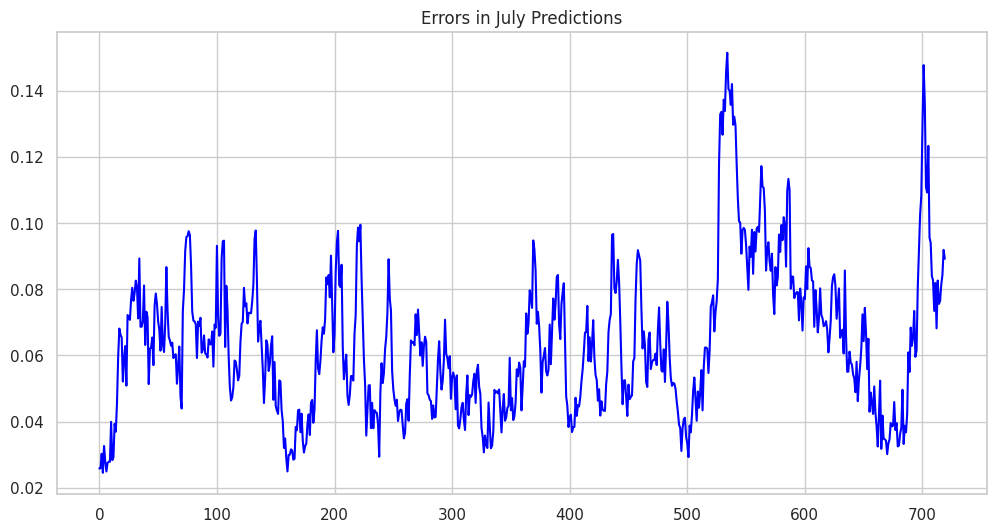

In [ ]:
errors = preds_july_np - true_july_np
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)
abs_errors = np.abs(errors)
abs_error_mean = np.mean(abs_errors, axis=0)
abs_error_std = np.std(abs_errors, axis=0)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(abs_error_mean, label='Mean Error', color='blue')
# plt.fill_between(range(len(abs_error_mean)), abs_error_mean - abs_error_std, abs_error_mean + abs_error_std, color='blue', alpha=0.2)
plt.title('Errors in July Predictions')


In [ ]:
preds_august_np = preds_august_np.T

In [ ]:
pd.DataFrame(preds_august_np).to_csv('predictions/august_predictions.csv', index=False)